# EDA

### Índice
- Preprocesado
- Stop words
- Lemmatización
- TF-IDF
- KeyWords
   - Bigrama
   - Trigrama
   - WordCount
   - WordCloud


In [1]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from itertools import chain
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Leer el archivo
df = pd.read_csv('fake_or_real_news.csv')
print(list(df.columns))
df = df.drop(['Unnamed: 0', 'title'], axis=1)
df

['Unnamed: 0', 'title', 'text', 'label']


,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [3]:
# Analizar duplicados
print(f"Valores nulos: \n{df.duplicated().sum(axis = 0)}")

# Analizar nulos
print(f"Valores nulos: \n{df.isnull().sum(axis = 0)}")

Valores nulos: 
275
Valores nulos: 
text     0
label    0
dtype: int64


In [4]:
# Eliminar valores duplicados
df = df.drop_duplicates()

In [5]:
# Comprobar nuevas dimensiones del dataframe
df.shape

(6060, 2)

In [6]:
# Analizar balance de la variable target
df.label.value_counts()

FAKE    3071
REAL    2989
Name: label, dtype: int64

### Preprocesado

In [7]:
# Transformar la variable label a binaria
target = df['label'].map({'REAL':0,'FAKE':1})

In [8]:
# Eliminar los caracteres especiales y convertimos a minusculas
translator = str.maketrans('', '', string.punctuation+'’‘—“”–')
df["text"] = df['text'].map(lambda x: x.strip().lower().translate(translator))

In [9]:
# Eliminar los numeros
r = re.compile('\d+')
df['text'] = df['text'].apply(lambda x: r.sub(' ', x))

# Eliminar los espacios en blanco duplicados
r = re.compile('\\s+')
df['text'] = df['text'].apply(lambda x: r.sub(' ', x))

### Stop words


In [10]:
# Descargar los paquetes de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
# Tokenizar y eliminar stopwords
stopwords = nltk.corpus.stopwords.words('english')
df['text'] = df['text'].map(word_tokenize).apply(lambda x: [word for word in x if word not in stopwords])

### Lemmatizacion

In [12]:
# Aplicar lemmatizador sobre los verbos
wordnet_lemmatizer = WordNetLemmatizer()
df['lemma'] = df['text'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word, pos=("v")) for word in x])

In [13]:
# Comprobar la lemmatizacion
df[['text', 'lemma']].iloc[30:40]

,text,lemma
30,"[day, j, fred, buzhardt, lawyer, defending, pr...","[day, j, fred, buzhardt, lawyer, defend, presi..."
31,"[randy, maugans, jeffrey, sewell, metabiology,...","[randy, maugans, jeffrey, sewell, metabiology,..."
32,"[previous, article, discussed, stretchingnamel...","[previous, article, discuss, stretchingnamely,..."
33,"[britain, eu, brexit, brexit, prompts, unietd,...","[britain, eu, brexit, brexit, prompt, unietd, ..."
34,"[posted, october, carl, herman, use, trying, e...","[post, october, carl, herman, use, try, escape..."
35,"[trump, raises, concern, members, urban, commu...","[trump, raise, concern, members, urban, commun..."
36,"[first, ever, hindu, elected, us, house, repre...","[first, ever, hindu, elect, us, house, represe..."
37,"[topics, anthony, weiner, presidential, politi...","[topics, anthony, weiner, presidential, politi..."
38,"[exassistant, fbi, director, clintons, crime, ...","[exassistant, fbi, director, clintons, crime, ..."
39,"[first, bill, hillary, clinton, copresidency, ...","[first, bill, hillary, clinton, copresidency, ..."


In [14]:
# Guardar el dataframe con la variable target
df_target = pd.concat([df, target], axis=1)
df_target.to_csv('df_target.csv', index=False)

### TF-IDF (Scikit-learn)

Aplicamos TF-IDF a las notícias para extraer las palabras más relevantes de todas ellas además de bigramas y trigramas más relevantes.

In [15]:
# Creamos corpus para tener todas las palabras en un array
corpus = df['lemma'].apply(lambda x: ' '.join(x)).to_numpy()

In [16]:
# Convertir palabras a vectores ademas de propiedades de TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000, max_df=0.9, min_df=0.2)
vectors = vectorizer.fit_transform(corpus)

In [17]:
# Observar las 182 feature_name con sus porcentajes tf-idf en cada noticia
featured_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=featured_names)
df_tfidf

,accord,act,add,allow,already,also,america,american,americans,among,...,white,win,without,work,world,would,write,year,years,yet
0,0.000000,0.156249,0.000000,0.038376,0.074463,0.046324,0.000000,0.000000,0.037529,0.000000,...,0.000000,0.000000,0.07373,0.000000,0.000000,0.022490,0.000000,0.000000,0.056750,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.094461,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.084129,0.057061,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.114538,0.000000,0.000000,0.000000,0.000000,0.000000,0.277816,0.000000,0.108629,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083200,0.00000
3,0.073568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082956,...,0.000000,0.000000,0.00000,0.126804,0.000000,0.000000,0.079410,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.049913,0.000000,0.000000,0.000000,0.000000,...,0.072941,0.551964,0.00000,0.000000,0.000000,0.048466,0.000000,0.000000,0.061147,0.08109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,0.031133,0.000000,0.066828,0.000000,0.000000,0.065845,0.000000,0.000000,0.000000,0.035106,...,0.000000,0.000000,0.00000,0.134154,0.000000,0.021312,0.000000,0.061027,0.080664,0.00000
6056,0.021041,0.000000,0.022582,0.024577,0.000000,0.014833,0.094138,0.202260,0.000000,0.023726,...,0.043354,0.000000,0.00000,0.000000,0.191121,0.014403,0.022712,0.000000,0.090859,0.00000
6057,0.025537,0.030363,0.000000,0.000000,0.000000,0.036007,0.085692,0.147291,0.204195,0.000000,...,0.052619,0.028442,0.05731,0.044017,0.025774,0.069926,0.000000,0.000000,0.000000,0.00000
6058,0.079993,0.000000,0.085854,0.000000,0.000000,0.084591,0.000000,0.038448,0.000000,0.045101,...,0.123618,0.000000,0.00000,0.068939,0.040367,0.054759,0.000000,0.117603,0.138172,0.00000


### KeyWords

In [18]:
# Palabras mas relvantes de todas las noticias
feature_array = np.array(vectorizer.get_feature_names_out())
tfidf_array = np.argsort(vectors.toarray()).flatten()[::-1] #flatten, matrix to one dimension array

n = 5
top_n = feature_array[tfidf_array][:n]
top_n

array(['trump', 'attack', 'say', 'former', 'try'], dtype=object)

#### Bigram

In [19]:
# Buscar bigramas mas relevantes
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=10000, max_df=0.9, min_df=0.05)
vectors = vectorizer.fit_transform(corpus)

In [20]:
featured_names = vectorizer.get_feature_names_out()
featured_names

array(['american people', 'associate press', 'barack obama',
       'bernie sanders', 'bill clinton', 'clinton campaign',
       'clinton say', 'democratic party', 'donald trump', 'dont know',
       'dont think', 'even though', 'first time', 'foreign policy',
       'fox news', 'general election', 'george bush', 'hillary clinton',
       'hillary clintons', 'islamic state', 'jeb bush', 'last week',
       'last year', 'law enforcement', 'look like', 'make sure',
       'marco rubio', 'middle east', 'national security', 'new hampshire',
       'new york', 'obama administration', 'president barack',
       'president obama', 'presidential campaign',
       'presidential candidate', 'presidential election',
       'presidential nominee', 'republican party',
       'republican presidential', 'say trump', 'say would',
       'secretary state', 'social media', 'state department',
       'supreme court', 'take place', 'ted cruz', 'trump campaign',
       'trump say', 'unite state', 'vice pre

In [21]:
# Top 5 bigramas
feature_array = np.array(vectorizer.get_feature_names())
tfidf_array = np.argsort(vectors.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_array][:n]
top_n

array(['new hampshire', 'jeb bush', 'say trump', 'donald trump',
       'social media'], dtype='<U23')

#### Trigram

In [22]:
# Buscar trigramas mas relevantes
vectorizer = TfidfVectorizer(ngram_range=(3, 3), max_features=10000, max_df=0.9, min_df=0.025)
vectors = vectorizer.fit_transform(corpus)

In [23]:
featured_names = vectorizer.get_feature_names()
featured_names

['associate press contribute',
 'fbi director jam',
 'former secretary state',
 'new york time',
 'president barack obama',
 'president unite state',
 'press contribute report',
 'private email server',
 'sen bernie sanders',
 'sen marco rubio',
 'sen ted cruz',
 'wall street journal']

In [24]:
# Top 5 trigramas
featured_names = vectorizer.get_feature_names()
featured_names
feature_array = np.array(vectorizer.get_feature_names())
tfidf_array = np.argsort(vectors.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_array][:n]
top_n

array(['wall street journal', 'sen ted cruz', 'sen marco rubio',
       'sen bernie sanders', 'private email server'], dtype='<U26')

#### WordCount

No tiene en cuenta los vectores y propiedades TF-IDF

<AxesSubplot:>

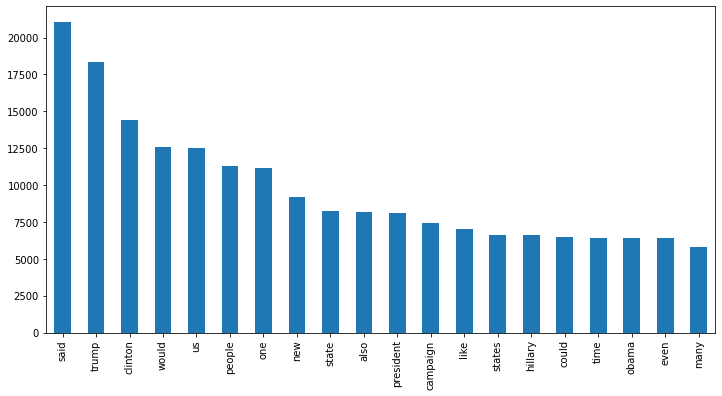

In [25]:
# Generar wordcount con palabras mas mencionadas
words = list(chain(*df['text']))
pd.Series(Counter(words)).sort_values(ascending=False).iloc[:20].plot(kind="bar", figsize=(12, 6))

#### WordCloud

No tiene en cuenta los vectores y propiedades TF-IDF

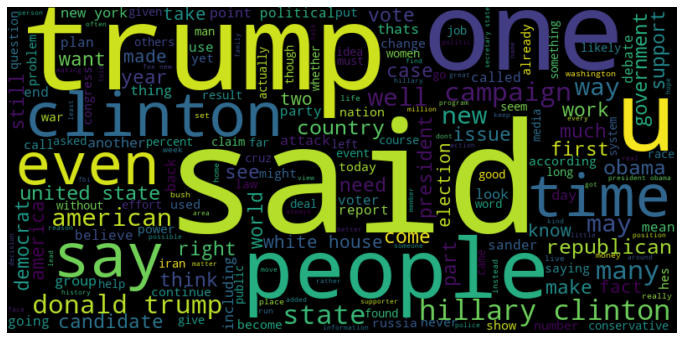

In [26]:
# Generar wordcloud con palabras mas mencionadas
join_words = ' '.join(words)
wordcloud = WordCloud(width=800, height=400).generate(join_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()